# Maximum Likelihood Estimation

Authors: Audrey Olivier, Dimitris G. Giovanis
Last modified on 12/10/2018 by Audrey Olivier

This notebook illustrates the use of the Model class to create a model for inference, and maximum likelihood estimation of the parameters of that model. In particular, the following models are illustrated:
- a probability model with an existing fit method,
- a probability model without a fit method (custom distribution, or distribution with copulas),
- a python model defined with RunModel.

## Probability distribution model with an existing fit method

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from UQpy.Inference import Model, MLEstimation
from UQpy.Distributions import Distribution

(1000,)


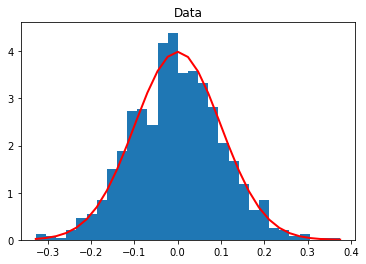

In [2]:
mu, sigma = 0, 0.1 # true mean and standard deviation
data = np.random.normal(mu, sigma, 1000)
print(data.shape)

count, bins, ignored = plt.hist(data, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.title('Data')
plt.show()

Create an instance of the class Model. The user must define the number of parameters to be estimated, in this case 2 (mean and standard deviation). For maximum likelihood estimation, no prior pdf is required.

In [3]:
candidate_model = Model(model_type = 'pdf', n_params = 2, model_name = 'normal')

Perform maximum likelihood. Setting verbose=True, some comments are written and one can see that the maximul likelihood procedure uses the fit method of the probability distribution.

In [4]:
ml_estimator = MLEstimation(model=candidate_model, data=data, verbose=True)
print('ML estimates of the mean={0:.3f} and std. dev={1:.3f}'.format(ml_estimator.param[0], ml_estimator.param[1]))

Evaluating max likelihood estimate for model normal using its fit method.
Max likelihood estimation completed.
ML estimates of the mean=-0.003 and std. dev=0.104


## Probability model for which the fit method is not defined.

Here we define a bivariate probability model, with a dependence structure defined using a gumbel copula. The goal of inference is to learn the paremeters of the Gaussian marginals and the copula parameter, i.e., the model has 5 unknown parameters. 

First data is generated using a true model and importance sampling/resampling, as a Distribution with copula does not possess a rvs method.

3
(5000, 2)


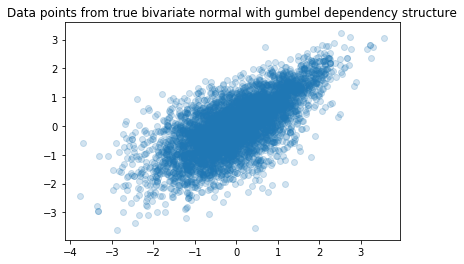

In [12]:
# dist_true exhibits dependence between the two dimensions, defined using a gumbel copula
dist_true = Distribution(name=['normal', 'normal'], copula='gumbel')
params_dist = [[0, 1], [0, 1]]
params_copula = 2

# generate data using importance sampling: sample from a bivariate gaussian without copula, then weight samples
from UQpy.SampleMethods import IS
u = IS(dimension=2, pdf_proposal=['normal']*2, pdf_proposal_params=[[0, 1], [0, 1]],
       pdf_target=['normal', 'normal'], pdf_target_copula='gumbel', pdf_target_params=[[0, 1], [0, 1]], 
       pdf_target_copula_params = [2], 
       nsamples=500000)
# Resample to obtain 5,000 data points
data = u.resample(size=5000)
print(data.shape)

fig, ax = plt.subplots()
ax.scatter(data[:,0], data[:,1], alpha=0.2)
ax.set_title('Data points from true bivariate normal with gumbel dependency structure')
plt.show()

To define a model for inference, the user must create a custom file, here bivariate_normal_gumbel.py, to compute the log_pdf of the distribution, given a bivariate data matrix and a parameter vector of length 5. Note that for any probability model that is not one of the simple univariate pdfs supported by UQpy, such custom file should be created.

In [13]:
candidate_model = Model(model_type = 'pdf', n_params = 5, model_name = 'bivariate_normal_gumbel')

In [14]:
ml_estimator = MLEstimation(model=candidate_model, data=data, verbose=True,
                            bounds = [[-5, 5], [0, 10], [-5, 5], [0, 10], [1, 5]], iter_optim=10,
                            method_optim='SLSQP')

print('ML estimates of the mean={0:.3f} and std. dev={1:.3f} of 1st marginal (true: 0.0, 1.0)'.
      format(ml_estimator.param[0], ml_estimator.param[1]))
print('ML estimates of the mean={0:.3f} and std. dev={1:.3f} of 2nd marginal (true: 0.0, 1.0)'.
      format(ml_estimator.param[2], ml_estimator.param[3]))
print('ML estimates of the copula parameter={0:.3f} (true: 2.0)'.format(ml_estimator.param[4]))

Evaluating max likelihood estimate for model bivariate_normal_gumbel using optimization procedure.
Max likelihood estimation completed.
ML estimates of the mean=-0.019 and std. dev=0.983 of 1st marginal (true: 0.0, 1.0)
ML estimates of the mean=-0.001 and std. dev=0.987 of 2nd marginal (true: 0.0, 1.0)
ML estimates of the copula parameter=1.974 (true: 2.0)


## Regression model (model linear in the parameters)

Here a model is defined that is of the form 

$$y=f(\theta) + \epsilon$$

where f consists in running RunModel. In particular, here $f(\theta)=\theta_{0} x + \theta_{1} x^{2}$ is a regression model.

First we generate synthetic data, and add some noise to it.

In [8]:
# Generate data
from scipy.stats import multivariate_normal

param_true = np.array([1.0, 2.0]).reshape((1, -1))
error_covariance = np.eye(50)

print(param_true.shape)
from UQpy.RunModel import RunModel
z = RunModel(samples=param_true, model_script='pfn_models.py', model_object_name = 'model_quadratic', 
             var_names = ['theta_1', 'theta_2'])
data = z.qoi_list[0].reshape((-1,))+multivariate_normal.rvs(mean=None, cov=error_covariance, size=1)
print(data)

(1, 2)
[-7.21009358e-02 -1.67051658e+00  4.52695983e-01  7.02124027e-01
  3.30587833e+00  3.70389206e+00  4.22093103e+00  5.66113354e+00
  7.95862139e+00  9.09612232e+00  1.02897731e+01  1.28287893e+01
  1.45976386e+01  1.60621238e+01  2.09419473e+01  2.27475762e+01
  2.48248577e+01  2.75675196e+01  3.02121336e+01  3.29109645e+01
  3.65917382e+01  4.06837109e+01  4.52283407e+01  4.87894162e+01
  5.33937978e+01  5.98515814e+01  6.12219753e+01  6.72896628e+01
  7.01830750e+01  7.63780938e+01  8.06634760e+01  8.47921748e+01
  9.33661051e+01  9.80013660e+01  1.02290060e+02  1.08415244e+02
  1.14975538e+02  1.19511307e+02  1.29982796e+02  1.35735432e+02
  1.39226253e+02  1.46701083e+02  1.53730444e+02  1.63276898e+02
  1.69095533e+02  1.77105168e+02  1.86947008e+02  1.94486940e+02
  2.02471275e+02  2.07922873e+02]


Then we create an instance of the Model class, using model_type='python'. Then we perform maximul likelihood estimation of the two parameters.

In [9]:
candidate_model = Model(n_params=2, model_type='python', 
                        model_script='pfn_models.py', model_object_name = 'model_quadratic', 
                        error_covariance=error_covariance, var_names = ['theta_1', 'theta_2'])

In [10]:
ml_estimator = MLEstimation(model=candidate_model, data=data)

In [11]:
print(ml_estimator.param)

[1.10322074 1.98343126]
